# Decision Trees and Random Forests Project

## From Pierian Data's Python for Data Science and Machine Learning Boot Camp

This project explores publicly available data from LendingClub.com (for years 2007-2010). Lending Club connects people who need money (borrowers) with people who have money (investors). The goal is to build a model that can predict which borrows have a high probabily of paying back their loans.

Data set column descriptions:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Exploration

In [2]:
data = pd.read_csv(r'data/loan_data.csv') # Load data set.
data.head(10)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
5,1,credit_card,0.0788,125.13,11.904968,16.98,727,6120.041667,50807,51.0,0,0,0,0
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0,0,1,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0,0,0,1
8,1,home_improvement,0.1134,87.19,11.407565,17.25,682,3989.000000,69909,51.1,1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


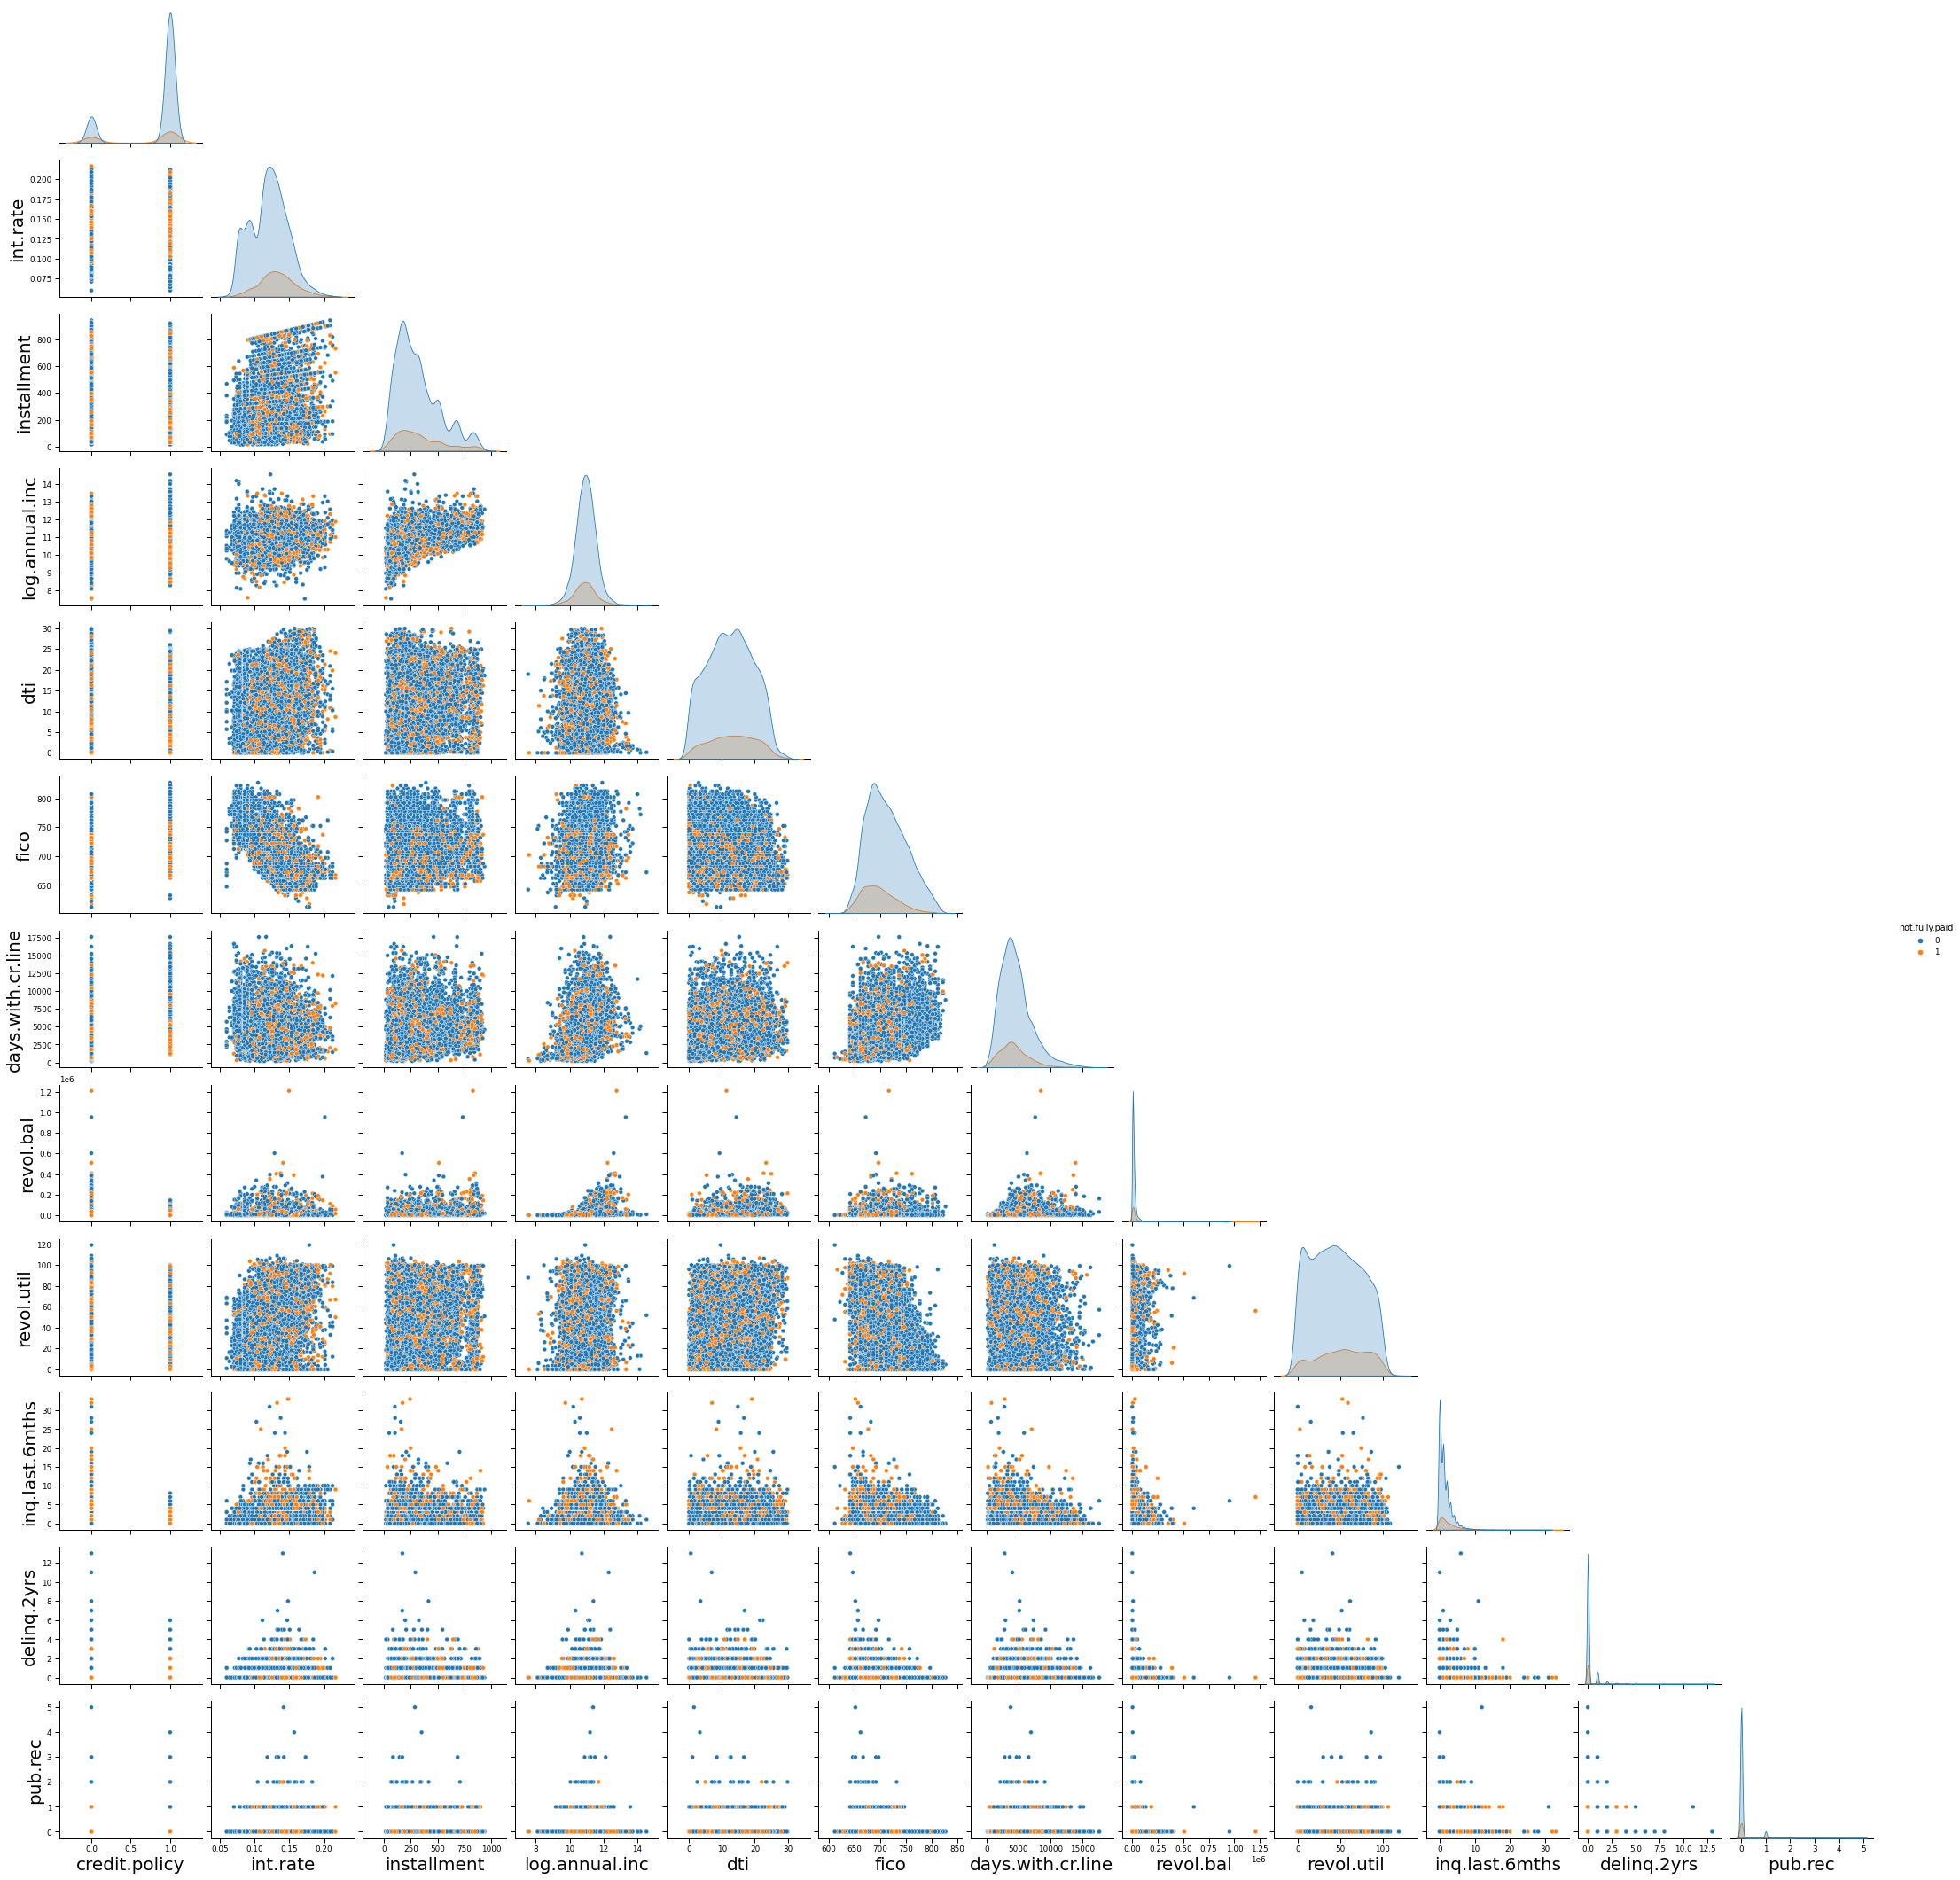

In [4]:
sns.set_context("paper", rc={"axes.labelsize":20})
sns.pairplot(data=data, hue='not.fully.paid', corner=True)

<AxesSubplot:xlabel='purpose', ylabel='count'>

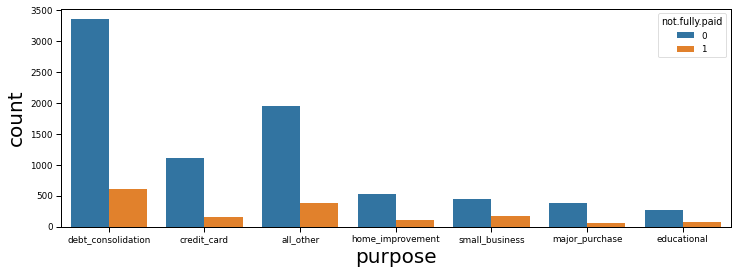

In [5]:
fig = plt.figure(figsize=(12,4))
sns.countplot(data=data, x='purpose', hue='not.fully.paid')

<AxesSubplot:xlabel='not.fully.paid', ylabel='count'>

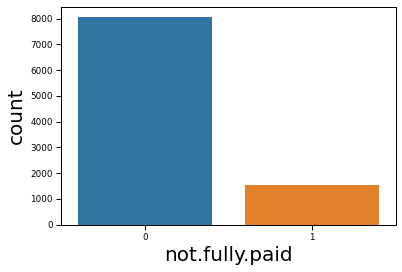

In [6]:
sns.countplot(data=data, x='not.fully.paid')

There are 9 continuous features, 3 descrete features, 1 qualitative feature with several classifications.  

Debt consolidation is the most common reason for a loan request and makes up about a third of total requests. Credit card and 'other' categories make up another third. For all categories, the number of borrowers who did not fully repay their loans is smaller than those who did. In total, about 1 out of every 6 borrowers did not fully repay.  

There is no immediately clear splitting between borrowers who did vs. did not pay back their balance for pairs of model features.

There are not many clear pairs of variables which are correlated, except for 'fico' vs. 'int.rate' and 'log.annual.inc' vs 'installment'. Both of these seem reasonable, even trivial. Borrowers with higher FICO scores are expected to get lower interest rates, and borrowers with higher income can afford higher monthly installments.

## Gauge Performance of a Single Decision Tree

To use the 'purpose' column data, replace it with a set of numerical 0-1 columns for each category:

In [7]:
data_numerical = pd.get_dummies(data, columns=['purpose'], drop_first=True)
print(data_numerical.columns) # check

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business'],
      dtype='object')


Split data set into training and testing data:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = data_numerical.drop('not.fully.paid', axis=1)
y = data_numerical['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Fit desicion tree with sklearn:

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

Performance metrics:

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
y_pred = dtc.predict(X_test)

In [14]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2226  424]
 [ 400  111]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2650
           1       0.21      0.22      0.21       511

    accuracy                           0.74      3161
   macro avg       0.53      0.53      0.53      3161
weighted avg       0.74      0.74      0.74      3161



**Assessment:**

The single decision tree performed at close to 85% in all performance metrics for detecting borrowers who will pay their loan back. It performs much lower, 20% for detecting borrowers who will not pay back their full loan. This is not surprising since there are are 5x less borrowers who did not pay back. In fact, the number of false positives and false negatives are almost equal. However, it is likely that Lending Club would like a much higher performance in determining true positives since these translate to direct losses.

## Train a Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

Train and predict:

In [16]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train) # use same training set as for decision tree.

RandomForestClassifier(n_estimators=200)

In [17]:
y_pred = rfc.predict(X_test)

Performance metrics:

In [18]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2637   13]
 [ 504    7]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2650
           1       0.35      0.01      0.03       511

    accuracy                           0.84      3161
   macro avg       0.59      0.50      0.47      3161
weighted avg       0.76      0.84      0.77      3161



**Assessment:**

In terms of total number of sucessful classifications (e.g. weighted metrics in the classification report), the random forest performs better than the single decision tree. However, the better performance comes from increases in true negatives at the cost of true positives (those who will not pay back loans). 

The random forest is trying to maximize its total number of correct classifications instead of acheiving equally good predictions for both classification types. One solution therefore may be to remove some of the the 'not.fully.paid'=0 rows to match the numer of 'not.fully.paid'=1 rows and then rerun the random forest.

## Feature Importances

In [19]:
rfc.feature_importances_

array([0.01559806, 0.10438113, 0.11425254, 0.11166873, 0.11100596,
       0.07847501, 0.113563  , 0.11172693, 0.11125896, 0.0534906 ,
       0.01444871, 0.00951436, 0.00774387, 0.01479404, 0.0065571 ,
       0.00777955, 0.00416536, 0.00957611])

None of the features has a primary influence on the classification. Several of the features each have about a 10 % importance.

The Lending Club credit policy feature (1st feature) has low predictive importance (~1.5%) for loan repayment. Depending on how much time and cost is associated with performing any financial analysis or risk assessment associated with the credit policy metric, it may be profitable to discontinue it. 